In [1]:
"""
!git clone -b EMT https://github.com/pop756/Quantum_KAN.git
%cd Quantum_KAN
!pip install -r requirements.txt"""

'\n!git clone -b EMT https://github.com/pop756/Quantum_KAN.git\n%cd Quantum_KAN\n!pip install -r requirements.txt'

In [1]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np
from qiskit.compiler import transpile
from qiskit_ibm_runtime.options import TwirlingOptions
from qiskit.quantum_info import SparsePauliOp

def create_trotterized_ising_model_circuit(num_qubits, trotter_steps, time):
    """
    Trotterization을 사용하여 Ising 모델의 양자 서킷을 생성합니다.
    각 Rz 게이트의 파라미터는 Qiskit Parameter로 동적으로 설정됩니다.

    Parameters:
    - num_qubits: 큐비트의 수
    - trotter_steps: Trotterization 단계 수
    - time: 진화 시간

    Returns:
    - QuantumCircuit: 생성된 양자 서킷
    - dict: 서킷 파라미터 사전
    """
    qc = QuantumCircuit(num_qubits)
    delta_t = 1

    # 파라미터 설정
    h_params = [Parameter(f'h_{i}') for i in range(num_qubits)]
    J_params = [[Parameter(f'J_{i}_{j}') for j in range(num_qubits)] for i in range(num_qubits)]

    for _ in range(trotter_steps):
        # 자기 상호작용 항목 추가
        for i in range(num_qubits):
            qc.rx(2 * h_params[i] * delta_t, i)

        # 스핀 간 상호작용 항목 추가
        for i in range(num_qubits-1):
            if J_params[i][i+1] != 0:
                qc.cx(i, i+1)
                qc.rz(2 * J_params[i][i+1] * delta_t, i+1)
                qc.cx(i, i+1)

    return qc, h_params, J_params


# ECR 게이트를 제거하는 함수
def remove_ecr_gates(circuit):
    new_circuit = QuantumCircuit(circuit.num_qubits)
    for instr, qargs, cargs in circuit.data:
        if instr.name != 'ecr':
            new_circuit.append(instr, qargs, cargs)
    return new_circuit

# 파라미터 설정
trotter_steps = 3  # Trotterization 단계 수
time = 1.0  # 진화 시간
num_qubits = 8
init_p  =['I' for i in range(num_qubits)]
p_list = []
for i in range(num_qubits):
  temp = init_p.copy()
  temp[i] = 'Z'
  p_list.append(''.join(temp))


hamiltonian = SparsePauliOp.from_list([(p_list[i],1) for i in range(num_qubits)])


In [2]:


# Initialize your account
from qiskit_ibm_runtime import QiskitRuntimeService
import qiskit_ibm_provider
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes,EfficientSU2

service = QiskitRuntimeService(channel='ibm_quantum',
    instance='ibm-q-skku/skku/skku-students',
    token = '06f802eeac992c43c4106753d7c5fc31414a13eb7d91c99d67fb49cc50569e5b4b011f20c71b9607a07cb43ecc7044557c699022db91d1685ba4c886d5886854')

qubit_use = [117,118,119,120,121,122,123,124]




trotterized_ising_circuit, h_params, J_params = create_trotterized_ising_model_circuit(8, trotter_steps, time)
ansatz = EfficientSU2(8, reps=4)

C:\Users\pop75\AppData\Local\Temp\ipykernel_31172\4088231857.py:3: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  import qiskit_ibm_provider


In [5]:
#setting
optimization_level = 0
resilience_level = 1
l = 0
stretch = 3
T_options = TwirlingOptions(enable_gates=True)

In [410]:
from qiskit.compiler import transpile
import copy
from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit.circuit import QuantumCircuit, Gate
from qiskit.pulse import builder, DriveChannel,Schedule,GaussianSquare,Drag,Play,ScheduleBlock,Delay
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 ,SamplerV2
from qiskit_ibm_runtime import Session
import numpy as np
from qiskit.primitives import StatevectorEstimator
import torch
from qiskit.quantum_info import SparsePauliOp
import pickle
import pandas as pd
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Batch
def remove_ecr_gates(circuit):
    new_circuit = QuantumCircuit(circuit.num_qubits)
    for instr, qargs, cargs in circuit.data:
        if instr.name != 'ecr':
            new_circuit.append(instr, qargs, cargs)
    return new_circuit

def check_connect(backend,init_list):
    min = np.min(np.array(init_list))
    connection_temp = []
    connection = []
    for item in backend.target['ecr']:
        if (item[0] in init_list) and (item[1] in init_list):
            connection.append(item)

    connection_temp = []
    for item in backend.target['ecr']:
        if (item[0] in init_list) and (item[1] in init_list):
            connection_temp.append((int(item[0]-min),int(item[1]-min)))

    return connection,connection_temp


def ecr_to_error(pulse_schedule,l):
    pulse_copy = copy.deepcopy(pulse_schedule)
    duration = round(pulse_copy.instructions[0][1].pulse.duration/32*l)*16
    width = round(pulse_copy.instructions[0][1].pulse._params['width']/32*l)*16
    x_duration = pulse_copy.instructions[2][1].pulse.duration
    sigma = round(pulse_copy.instructions[0][1].pulse._params['sigma']/32*l)*16
    amp = pulse_copy.instructions[0][1].pulse._params['amp']/l
    if sigma == 0:
        sigma = 1
    my_schedule = ScheduleBlock()
    signal_params = {'width':width,'sigma':sigma,'amp':amp}
    for j in range(2):
        pulse_copy = copy.deepcopy(pulse_schedule)
        pulse_input_x_1 = pulse_copy.instructions[0][1]
        pulse_input_x_2 = pulse_copy.instructions[3][1]
        pulse_input_c_1 = pulse_copy.instructions[1][1]
        #pulse_input_c_1.pulse._params['angle'] = 0
        pulse_input_c_1.pulse._params.update(signal_params)
        pulse_input_c_1.pulse.duration = duration
        pulse_input_x_1.pulse._params.update(signal_params)
        pulse_input_x_1.pulse.duration = duration
        pulse_input_drag = pulse_copy.instructions[2][1]
        if j == 1:
            pulse_input_drag.pulse._params['angle'] = 3.14
        pulse_input_c_2 = pulse_copy.instructions[4][1]
        pulse_input_c_2.pulse.duration = duration
        pulse_input_c_2.pulse._params.update(signal_params)
        pulse_input_x_2.pulse._params.update(signal_params)
        pulse_input_x_2.pulse.duration = duration
        real_pulse = ScheduleBlock()
        real_pulse += pulse_input_c_1
        real_pulse += pulse_input_x_1
        real_pulse += Delay(x_duration,pulse_input_c_1.channel)
        real_pulse += Delay(x_duration,pulse_input_x_1.channel)
        real_pulse +=  pulse_input_c_2
        real_pulse += pulse_input_x_2
        real_pulse += Delay(duration,pulse_input_drag.channel)
        real_pulse += pulse_input_drag
        my_schedule += real_pulse
    return my_schedule


def ecr_to_schedule(pulse_schedule,stretch):
    pulse_copy = copy.deepcopy(pulse_schedule)
    my_schedule = ScheduleBlock()
    duration = round(pulse_copy.instructions[0][1].pulse.duration/16*stretch)*16
    width = round(pulse_copy.instructions[0][1].pulse._params['width']/16*stretch)*16
    x_duration = pulse_copy.instructions[2][1].pulse.duration
    sigma = round(pulse_copy.instructions[0][1].pulse._params['sigma']/16*stretch)*16
    amp = pulse_copy.instructions[0][1].pulse._params['amp']/stretch
    
    pulse_input_x_1 = pulse_copy.instructions[0][1]
    pulse_input_x_2 = pulse_copy.instructions[3][1]
    pulse_input_c_1 = pulse_copy.instructions[1][1]
    pulse_input_drag = pulse_copy.instructions[2][1]
    pulse_input_c_2 = pulse_copy.instructions[4][1]
    signal_params = {'width':width,'sigma':sigma,'amp':amp}
    pulse_input_c_1.pulse._params.update(signal_params)
    pulse_input_c_1.pulse.duration = duration
    pulse_input_x_1.pulse._params.update(signal_params)
    pulse_input_x_1.pulse.duration = duration
    pulse_input_c_2.pulse.duration = duration
    pulse_input_c_2.pulse._params.update(signal_params)
    pulse_input_x_2.pulse._params.update(signal_params)
    pulse_input_x_2.pulse.duration = duration
    real_pulse = ScheduleBlock()
    real_pulse += pulse_input_c_1
    real_pulse += pulse_input_x_1
    real_pulse += Delay(x_duration,pulse_input_c_1.channel)
    real_pulse += Delay(x_duration,pulse_input_x_1.channel)
    real_pulse +=  pulse_input_c_2
    real_pulse += pulse_input_x_2
    real_pulse += Delay(duration,pulse_input_drag.channel)
    real_pulse += pulse_input_drag
    my_schedule += real_pulse
    return my_schedule


def update_ecr(l,init_list,backend,stretch=1):
    backend_copy = copy.deepcopy(backend)
    for initial_layout in init_list:
        pulse_schedule = backend_copy.target['ecr'][initial_layout].calibration
        pulse_real = ecr_to_error(pulse_schedule,stretch)


        if l == 0:
            backend_copy.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(pulse_real)))
        else:
            my_schedule = ecr_to_error(pulse_schedule,l)
            backend_copy.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(pulse_real+my_schedule)))



    return backend_copy

def update_ecr_real(l,init_list,backend,stretch=1):
    backend_copy = copy.deepcopy(backend)
    layouts = {}
    for initial_layout in init_list:
        pulse_schedule = backend_copy.target['ecr'][initial_layout].calibration
        pulse_real = ecr_to_schedule(pulse_schedule,stretch)

        if l == 0:
            backend_copy.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(pulse_real)))
        else:
            my_schedule = ecr_to_error(pulse_schedule,l)
            backend_copy.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(pulse_real+my_schedule)))



    return backend_copy

class ZNE():
    def __init__(self,circ,H,backend,init_list,validation_size=100,train_size=100,stretch=1.5,ZNE_factor=[1,1.8,2.2,2.6]):
        """_summary_

        Args:
            circ (_type_): _input_circuit_
            H (_type_): _expectation_measure_basis_
            backend (_type_): _backend_
            init_list (_type_): _qubit_use_
            validation_size (int, optional): _size of validation_. Defaults to 100.
            train_size (int, optional): _size of train_. Defaults to 100.
            stretch (int, optional): _length of pulse at 1_. Defaults to 1.
            ZNE_factor (list, optional): _ZNE factor_. Defaults to [1,1.8,2.2,2.6].
        """
        self.H = H
        self.backend = backend
        self.validation_size = validation_size
        self.train_size = train_size
        self.stretch = stretch
        self.ZNE_factor = ZNE_factor
        
        connection,connection_temp = check_connect(backend,init_list)
        circ = transpile(circ,basis_gates=['rz','sx','x','ecr'],coupling_map=[list(i) for i in connection_temp],optimization_level=2,seed_transpiler=30)
        train_circ = remove_ecr_gates(circ)
        self.circ = circ
        self.train_circ = train_circ
        self.init_list = init_list
        self.connection = connection
        np.random.seed(30)
        self.train_parameters = np.random.uniform(-3.14, 3.14, [train_size,len(circ.parameters)])
        np.random.seed(60)
        self.valid_parameters = np.random.uniform(-3.14, 3.14, [validation_size,len(circ.parameters)])
    def ZNE_pulse(self,factor):
        backend_error = update_ecr(factor*self.stretch,self.connection,self.backend,stretch=self.stretch)
        backend_ecr = update_ecr_real(factor*self.stretch,self.connection,self.backend,stretch=self.stretch)
        return backend_error,backend_ecr
    
    def make_data(self):
        self.train_jobs = []
        self.valid_jobs = []
        for factor in self.ZNE_factor:
            backend_error,backend_ecr = self.ZNE_pulse(factor-1)
            #Train set 만들기
            passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend_error, initial_layout=self.init_list)
            qc_input = passmanager.run(self.circ)
            isa_observables = self.H.apply_layout(qc_input.layout)
            with Batch(backend = backend_error):
                estimator = EstimatorV2()
                job = estimator.run([(qc_input, isa_observables, self.train_parameters[i]) for i in range(self.train_size)])
                job.update_tags(['ecr_train',f"l={factor}",f"stretch={self.stretch}"])
                self.train_jobs.append(job)
            
            #Validation set 만들기
            passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend_ecr, initial_layout=self.init_list)
            qc_input = passmanager.run(self.circ)
            isa_observables = self.H.apply_layout(qc_input.layout)
            with Batch(backend = backend_ecr):
                estimator = EstimatorV2()
                job = estimator.run([(qc_input, isa_observables, self.valid_parameters[i]) for i in range(self.validation_size)])
                #job = sampler.run(qc_list,shots=8000)
                job.update_tags(['ecr',f"l={factor}","x"])
                self.valid_jobs.append(job)
    
    def make_label(self):
        estimator = StatevectorEstimator()
        job_train = estimator.run([(self.train_circ, self.H, self.train_parameters[i]) for i in range(self.train_size)])
        job_valid = estimator.run([(self.circ, self.H, self.valid_parameters[i]) for i in range(self.validation_size)])
        train_label = torch.tensor(np.array([result.data.evs for result in job_train.result()]),dtype=torch.float32)
        validation_label = torch.tensor(np.array([result.data.evs for result in job_valid.result()]),dtype=torch.float32)
        train_label = torch.reshape(train_label,[-1,1])
        validation_label = torch.reshape(validation_label,[-1,1])
        self.train_label = train_label
        self.validation_label = validation_label


    def run(self,made_data = True,make_label = True):
        """_summary_

        Args:
            make_data (bool, optional): _데이터를 이미 만들어 놓은지 유무_. Defaults to True.
            make_label (bool, optional): _label를 만들지 유무_. Defaults to True.
        """
        if not(made_data):
            self.make_data()
        import torch
        train_set = []
        valid_set = []

        for i in range(len(self.ZNE_factor)):
            train_list = []
            valid_list = []
            for res in self.train_jobs[i].result():
                train_list.append(res.data.evs)
            train_set.append(torch.tensor(np.array(train_list),dtype=torch.float32))


            for res in self.valid_jobs[i].result():
                valid_list.append(res.data.evs)
            valid_set.append(torch.tensor(np.array(valid_list),dtype=torch.float32))
        train_data = torch.stack(train_set,dim=1)
        train_data = train_data.to(torch.float32)
        validation_data = torch.stack(valid_set,dim=1)
        validation_data = validation_data.to(torch.float32)
        self.train_data = train_data
        self.validation_data = validation_data
        if make_label:
            self.make_label()
    def save(self,file_path):
        data_set = {'train_lable':torch.squeeze(self.train_label)}

        for index,l in enumerate(self.ZNE_factor):
            data_set[f'train(l={l})'] = self.train_data[:,index]

        data_set['validation_lable'] = torch.squeeze(self.validation_label)

        for index,l in enumerate(self.ZNE_factor):
            data_set[f'validation(l={l})'] = self.validation_data[:,index]
        data_frame = pd.DataFrame(data_set)
        data_frame.to_csv(file_path,index=False)
        

In [416]:
class train_ZNE():
    def __init__(self,backend,stretch_list,ecr_stretch=1,l=0,size=20):
        _,self.connect = check_connect(backend,[0,1])
        self.stretch_list = stretch_list
        self.size = size
        self.backend = backend
        self.l = l
        self.ecr_stretch = ecr_stretch
    def run(self):
        qc_list = []
        for i in range(self.size):
            qc = QuantumCircuit(2,2)
            for j in range(i):
                qc.ecr(*self.connect[0])
                qc.ecr(*self.connect[0])
            qc.measure_all()
            qc_list.append(qc)
        qc_list_odd = []
        for i in range(self.size):
            qc = QuantumCircuit(2,2)
            qc.ecr(*self.connect[0])
            for j in range(i):
                qc.ecr(*self.connect[0])
                qc.ecr(*self.connect[0])
            qc.measure_all()
            qc_list_odd.append(qc)
        self.job_stretch = {}
        self.job_stretch_odd = {}
        backend_ecr = update_ecr_real(self.l,self.connect,self.backend,self.ecr_stretch)
        passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend_ecr, initial_layout=[0,1])
        qc_input_ecr = passmanager.run(qc_list)
        with Batch(backend=backend_ecr):
            sampler = SamplerV2()
            job_test = sampler.run(qc_input_ecr)
            #job = sampler.run(qc_list,shots=8000)
            job_test.update_tags(['test','ecr',f'stretch = {self.ecr_stretch}',f'l = {self.l}'])
            self.job_test_list = job_test
        for stretch in self.stretch_list:
            backend_test = update_ecr(self.l,self.connect,self.backend,stretch)
            passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend_test, initial_layout=[0,1])
            qc_input_ecr = passmanager.run(qc_list)
            qc_input_ecr_odd = passmanager.run(qc_list_odd)
            with Batch(backend=backend_test):
                sampler = SamplerV2()
                job_test = sampler.run(qc_input_ecr)
                job_test.update_tags(['test','ecr_echo',f'stretch = {stretch}',f'l = {self.l}'])
                self.job_stretch[stretch] = job_test
                job_test = sampler.run(qc_input_ecr_odd)
                job_test.update_tags(['test_odd','ecr_echo',f'stretch = {stretch}',f'l = {self.l}'])
                self.job_stretch_odd[stretch] = job_test
        

In [345]:
zne_l_0 = train_ZNE(backend_kyoto,[1,1.2,1.4,1.6])
zne_l_0.run()

In [417]:
zne_l_1_5 = train_ZNE(backend_kyoto,[1,1.2,1.4,1.6],l=1.5)
zne_l_1_5.run()

In [418]:
zne_l_0_stretch = train_ZNE(backend_kyoto,[1,1.2,1.4,1.6],ecr_stretch=1.5)
zne_l_0_stretch.run()

In [419]:
zne_l_0_modif = train_ZNE(backend_kyoto,[1,1.2,1.4,1.6])
zne_l_0_modif.run()

In [393]:
zne_l_0_unstretch = train_ZNE(backend_kyoto,[1,1.2,1.4,1.5,1.6,1.7,1.8,2])
zne_l_0_unstretch.run()

['l = 0', 'stretch = 1', 'test', 'ecr_echo'] ['l = 0', 'stretch = 1.5', 'test', 'ecr']


([3098,
  2766,
  2448,
  2017,
  1618,
  1518,
  1531,
  1773,
  2033,
  2262,
  2442,
  2343,
  2195,
  1971,
  1725,
  1598,
  1553,
  1649,
  1845,
  1943],
 [3078,
  2888,
  2435,
  1866,
  1485,
  1195,
  1072,
  1077,
  1291,
  1524,
  1743,
  2068,
  2168,
  2193,
  2118,
  1934,
  1687,
  1502,
  1245,
  1203])

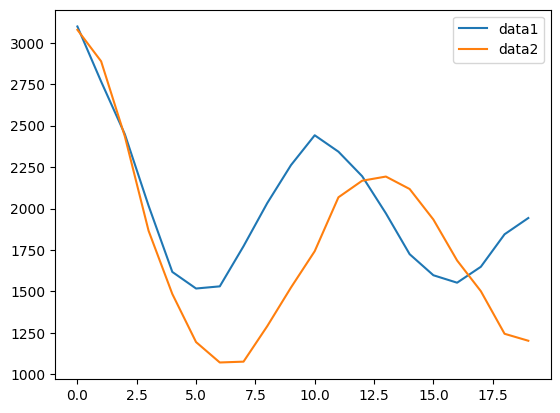

In [425]:
import matplotlib.pyplot as plt
def job_plot(job_1,job_2):
    print(job_1.tags,job_2.tags)
    job_1_result = job_1.result()
    job_2_result = job_2.result()
    data_1_list = []
    data_2_list = []
    for i in range(20):
        data_1 = job_1_result[i].data['meas'].get_counts()['00']
        data_2 = job_2_result[i].data['meas'].get_counts()['00']
        data_1_list.append(data_1)
        data_2_list.append(data_2)
    plt.plot(data_1_list,label='data1')
    plt.plot(data_2_list,label='data2')
    plt.legend()
    return data_1_list,data_2_list

job_plot(zne_l_0_stretch.job_stretch[1],zne_l_0_stretch.job_test_list)

['l = 0', 'stretch = 1.4', 'test', 'ecr_echo'] ['l = 0', 'stretch = 1.5', 'test', 'ecr']


([3019,
  1315,
  2724,
  1396,
  2459,
  1452,
  2220,
  1382,
  2062,
  1390,
  2109,
  1252,
  2028,
  1228,
  2026,
  1159,
  1970,
  1137,
  1930,
  1104],
 [3005,
  1277,
  2688,
  1195,
  2493,
  1158,
  2357,
  1092,
  2179,
  1168,
  2121,
  1091,
  2043,
  1099,
  1882,
  1127,
  1874,
  1068,
  1799,
  1053])

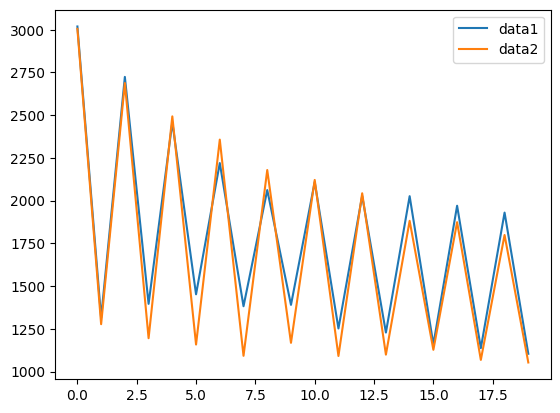

In [409]:
import matplotlib.pyplot as plt
def job_plot(job_1,job_2):
    print(job_1.tags,job_2.tags)
    job_1_result = job_1.result()
    job_2_result = job_2.result()
    data_1_list = []
    data_2_list = []
    for i in range(20):
        data_1 = job_1_result[i].data['meas'].get_counts()['00']
        data_2 = job_2_result[i].data['meas'].get_counts()['00']
        data_1_list.append(data_1)
        data_2_list.append(data_2)
    plt.plot(data_1_list,label='data1')
    plt.plot(data_2_list,label='data2')
    plt.legend()
    return data_1_list,data_2_list

job_plot(zne_l_0_stretch.job_stretch[1.4],zne_l_0_stretch.job_test_list)

In [211]:
job_result[1].data['meas'].get_counts()['00']

2985

In [120]:
stretch=1.5
ZNE_factor=[1,1.8,2.2,2.6]
backend_brisbane = service.backend('ibm_brisbane')
zne_brisbane = ZNE(trotterized_ising_circuit,hamiltonian,backend_brisbane ,[0,1,2,3,4,5,6,7],stretch=stretch,ZNE_factor=ZNE_factor)
zne_brisbane.make_data()

In [118]:
stretch=1.5
zne_brisbane_realamp = ZNE(ansatz,hamiltonian,backend_brisbane ,[0,1,2,3,4,5,6,7],stretch=stretch,ZNE_factor=ZNE_factor)
zne_brisbane_realamp.make_data()

In [381]:
backend_kyoto = service.backend('ibm_kyoto')
zne_kyoto = ZNE(trotterized_ising_circuit,hamiltonian,backend_kyoto,[79,80,81,82,83,84,85,86],stretch=1.6,ZNE_factor=[1,2,3,4])
zne_kyoto.make_data()

In [121]:
zne_kyoto_realamp = ZNE(ansatz,hamiltonian,backend_kyoto,[79,80,81,82,83,84,85,86],stretch=stretch,ZNE_factor=ZNE_factor)
zne_kyoto_realamp.make_data()

In [152]:
backend_osaka = service.backend('ibm_osaka')
zne_osaka = ZNE(trotterized_ising_circuit,hamiltonian,backend_osaka,[0,1,2,3,4,5,6,7],stretch=1,ZNE_factor=ZNE_factor)
zne_osaka.make_data()

In [123]:
zne_osaka_realamp = ZNE(ansatz,hamiltonian,backend_osaka,[0,1,2,3,4,5,6,7],stretch=stretch,ZNE_factor=ZNE_factor)
zne_osaka_realamp.make_data()

In [158]:
import torch
zne_osaka.run()
def get_data(zne):
    return zne.train_label,zne.validation_label,zne.train_data,zne.validation_data

train_label,validation_label,train_data,validation_data = get_data(zne_osaka)

In [175]:
backend_error,backend_ecr = zne_osaka.ZNE_pulse(0)

In [272]:
backend_ecr.target['ecr'][(1,0)].calibration

ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=600, sigma=32, width=472, amp=0.3241959792459389, angle=2.299061756929673, name='CR90p_u2'), ControlChannel(2), name='CR90p_u2'), Play(GaussianSquare(duration=600, sigma=32, width=472, amp=0.014298859946209065, angle=0.031750589929576786, name='CR90p_d0_u2'), DriveChannel(0), name='CR90p_d0_u2'), Delay(120, ControlChannel(2)), Delay(120, DriveChannel(0)), Play(GaussianSquare(duration=600, sigma=32, width=472, amp=0.32419597924593896, angle=-0.8425308966601202, name='CR90m_u2'), ControlChannel(2), name='CR90m_u2'), Play(GaussianSquare(duration=600, sigma=32, width=472, amp=0.014298859946209065, angle=-3.1098420636602166, name='CR90m_d0_u2'), DriveChannel(0), name='CR90m_d0_u2'), Delay(600, DriveChannel(1)), Play(Drag(duration=120, sigma=30, beta=-0.2582795674398735, amp=0.4769992714295254, angle=0.0, name='Xp_d1'), DriveChannel(1), name='Xp_d1'), name="block7863", transform=AlignLeft()), name="block7862", transform=AlignLeft())

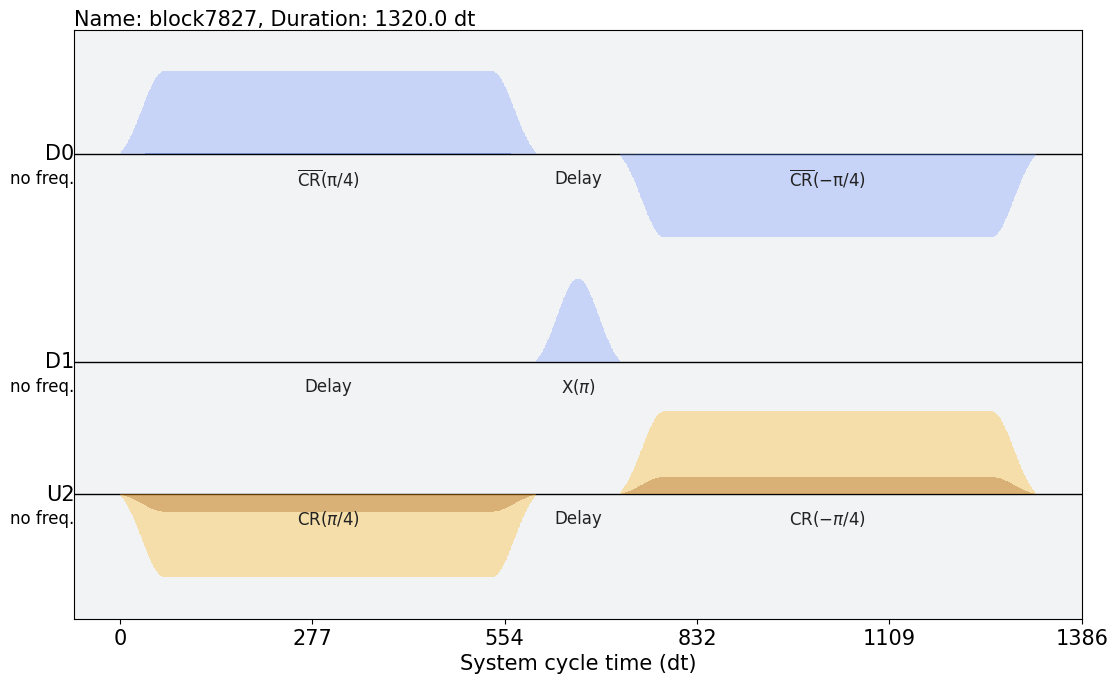

In [176]:
backend_ecr.target['ecr'][(1,0)].calibration.draw()

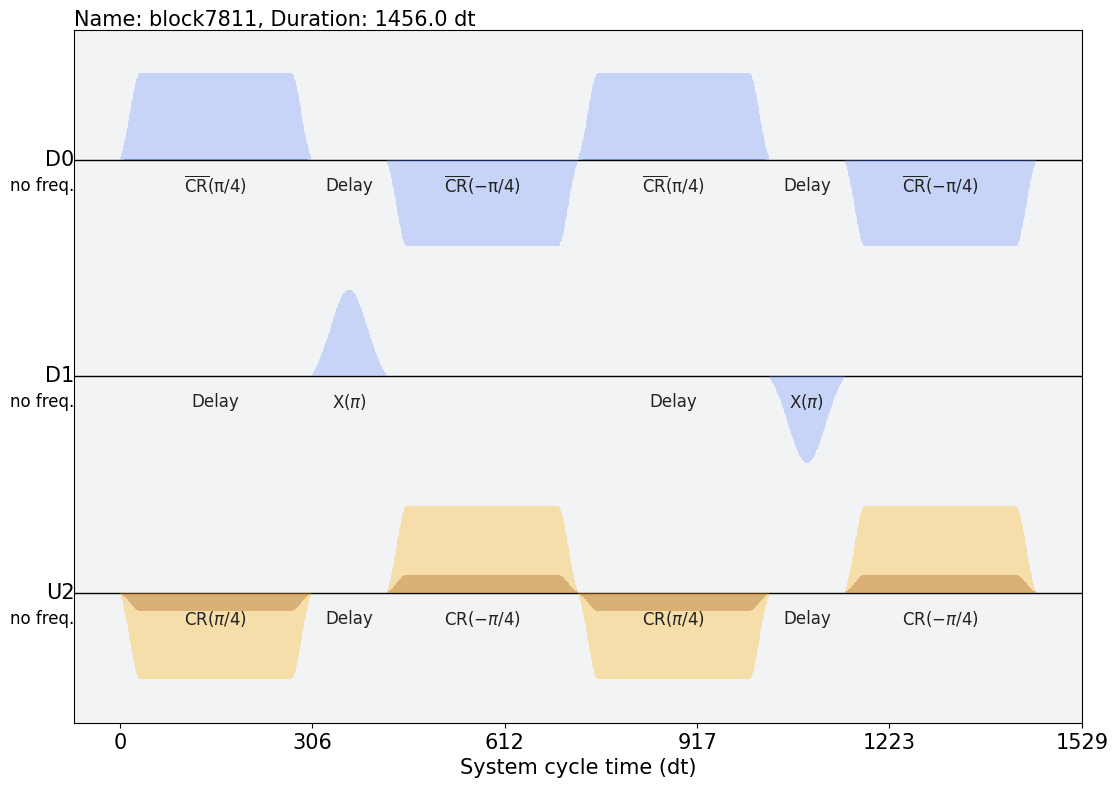

In [177]:
backend_error.target['ecr'][(1,0)].calibration.draw()

In [159]:
from functions.Error_mitigation import extrapolate_values
linear_data = []
exp_data = []

for data in validation_data:
    y_linear_0,y_exp_0,_,_ = extrapolate_values(data,np.array([1,2,3,4]))
    linear_data.append(y_linear_0)
    exp_data.append(y_exp_0)

linear_data = torch.tensor(np.array(linear_data),dtype=torch.float32)
exp_data = torch.tensor(np.array(exp_data),dtype=torch.float32)

In [160]:
import torch
import torch.nn as nn
print(f'Virtual ZNE MSE loss : {nn.MSELoss()(linear_data,torch.squeeze(validation_label))}' )
print(f'Virtual ZNE L1 loss :{nn.L1Loss()(linear_data,torch.squeeze(validation_label))}')

Virtual ZNE MSE loss : 1.8099850416183472
Virtual ZNE L1 loss :1.0969226360321045


In [156]:
print(f'Raw MSE loss : {nn.MSELoss()(validation_data[:,0],torch.squeeze(validation_label))}')
print(f'Raw L1 loss : {nn.L1Loss()(validation_data[:,0],torch.squeeze(validation_label))}')
print(f'Raw train MSE loss : {nn.MSELoss()(train_data[:,0],torch.squeeze(train_label))}')
print(f'Raw train L1 loss : {nn.L1Loss()(train_data[:,0],torch.squeeze(train_label))}')

Raw MSE loss : 1.267683982849121
Raw L1 loss : 0.9282559156417847
Raw train MSE loss : 2.239138126373291
Raw train L1 loss : 1.1533193588256836


C:\Users\pop75\AppData\Local\Temp\ipykernel_31172\3937314523.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_temp ), torch.tensor(train_label))
C:\Users\pop75\AppData\Local\Temp\ipykernel_31172\3937314523.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_dataset = TensorDataset(torch.tensor(validation_temp ), torch.tensor(validation_label))


Epoch 1/1500, Training Loss: 4.036693572998047, Validation Loss: 3.7124435901641846
Epoch 2/1500, Training Loss: 3.861910343170166, Validation Loss: 3.797255039215088
Epoch 3/1500, Training Loss: 3.6945059299468994, Validation Loss: 3.90671443939209
Epoch 4/1500, Training Loss: 3.5331850051879883, Validation Loss: 4.035946846008301
Epoch 5/1500, Training Loss: 3.377718925476074, Validation Loss: 4.182807922363281
Epoch 6/1500, Training Loss: 3.2273404598236084, Validation Loss: 4.350574493408203
Epoch 7/1500, Training Loss: 3.0813236236572266, Validation Loss: 4.546455383300781
Epoch 8/1500, Training Loss: 2.940350294113159, Validation Loss: 4.777891635894775
Epoch 9/1500, Training Loss: 2.8065786361694336, Validation Loss: 5.051329135894775
Epoch 10/1500, Training Loss: 2.6832568645477295, Validation Loss: 5.372215747833252
Epoch 11/1500, Training Loss: 2.5744259357452393, Validation Loss: 5.744055271148682
Epoch 12/1500, Training Loss: 2.4845924377441406, Validation Loss: 6.165973663

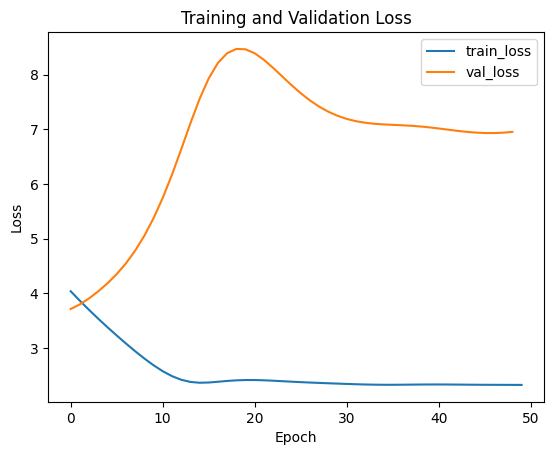

<built-in method stack of type object at 0x00007FFDFCF049D0>
MSELoss : 6.9744
L1Loss : 2.1891


C:\Users\pop75\AppData\Local\Temp\ipykernel_31172\3937314523.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_temp)


In [165]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from kan import KAN

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 10
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
early_stopping = EarlyStopping(patience=20, min_delta=0.025)
# 데이터셋 및 데이터로더
train_temp = validation_data[:]
validation_temp = validation_data[:]
train_dataset = TensorDataset(torch.tensor(train_temp ), torch.tensor(train_label))
validation_dataset = TensorDataset(torch.tensor(validation_temp ), torch.tensor(validation_label))
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=100, shuffle=False)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.KAN = KAN([train_temp.shape[1],1,1],grid=1)
    def forward(self, x):
        output = self.KAN(x)
        #output = nn.Sigmoid()(output)
        return output

# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(train_temp.shape[1], 32)
        self.layer2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output(x)
        return x

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True,dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.unsqueeze(x,2)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)  # LSTM의 초기 은닉 상태 초기화
        c0 = torch.zeros(1, x.size(0), self.hidden_size)  # LSTM의 초기 셀 상태 초기화
        out, _ = self.lstm(x, (h0, c0))  # LSTM을 통해 시퀀스 처리
        out = nn.Dropout(0.3)(out)
        out = self.fc(out[:, -1, :])  # 마지막 시퀀스의 출력을 fully connected layer에 적용하여 출력 생성
        return out

# 모델 초기화
#model =  LSTMModel(1,32,1)
#model =  MLP()
model =  Model()
#model.KAN.train(train_dict, steps=20, lamb=0.01, lamb_entropy=10.0)
# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

# 모델 학습
num_epochs = 1500
train_losses = []
validation_losses = []

for epoch in range(num_epochs):
    #model = model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    early_stopping(loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    validation_loss = 0.0
    #model = model.eval()
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
    

    validation_losses.append(validation_loss / len(validation_loader))

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {validation_losses[-1]}')

# 손실(loss) 그래프
plt.plot(train_losses, label='train_loss')
plt.plot(validation_losses, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 검증 데이터로 예측
with torch.no_grad():
    #model = model.eval()
    validation_inputs = torch.tensor(validation_temp)
    predictions = model(validation_inputs)
    print(torch.stack)
print(f'MSELoss : {float(torch.nn.MSELoss()(predictions,validation_label)):.4f}')
print(f'L1Loss : {float(torch.nn.L1Loss()(predictions,validation_label)):.4f}')


In [58]:
file_name = './Results/brisbane_realamp_stretch=1.2.csv'
zne_brisbane_realamp.save(file_name)
data = pd.read_csv(file_name)
data['prediction'] = torch.squeeze(predictions)
data.to_csv(file_name,index=False)

In [540]:
import copy
from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit.circuit import QuantumCircuit, Gate
from qiskit.pulse import builder, DriveChannel,Schedule,GaussianSquare,Drag,Play,ScheduleBlock,Delay
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 ,SamplerV2
from qiskit_ibm_runtime import Session
import numpy as np


init = '11'


error_gate = Gate(f"error", 2, [])
qc1 = QuantumCircuit(2, 2)
if init[0] == '1':
  qc1.x(0)
if init[1] == '1':
  qc1.x(1)
qc1.ecr(0,1)
qc1.measure(0,0)
qc1.measure(1,1)

def ecr_to_error(pulse_schedule,l):
  pulse_copy = copy.deepcopy(pulse_schedule)
  duration = round(pulse_copy.instructions[0][1].pulse.duration/32*l)*16
  width = round(pulse_copy.instructions[0][1].pulse._params['width']/32*l)*16
  x_duration = pulse_copy.instructions[2][1].pulse.duration
  sigma = round(pulse_copy.instructions[0][1].pulse._params['sigma']/32*l)*16
  angle = pulse_copy.instructions[0][1].pulse._params['angle']
  if sigma == 0:
    sigma = 1
  my_schedule = ScheduleBlock()
  signal_params = {'width':width,'sigma':sigma}
  for j in range(2):
    pulse_copy = copy.deepcopy(pulse_schedule)
    pulse_input_x_1 = pulse_copy.instructions[0][1]
    pulse_input_x_2 = pulse_copy.instructions[3][1]
    pulse_input_c_1 = pulse_copy.instructions[1][1]
    #pulse_input_c_1.pulse._params['angle'] = 0
    pulse_input_c_1.pulse._params.update(signal_params)
    pulse_input_c_1.pulse.duration = duration
    pulse_input_x_1.pulse._params.update(signal_params)
    pulse_input_x_1.pulse.duration = duration
    pulse_input_drag = pulse_copy.instructions[2][1]
    if j == 1:
        pulse_input_drag.pulse._params['angle'] = 3.14
    pulse_input_c_2 = pulse_copy.instructions[4][1]
    pulse_input_c_2.pulse.duration = duration
    pulse_input_c_2.pulse._params.update(signal_params)
    pulse_input_x_2.pulse._params.update(signal_params)
    pulse_input_x_2.pulse.duration = duration
    real_pulse = ScheduleBlock()
    real_pulse += pulse_input_c_1
    real_pulse += pulse_input_x_1
    real_pulse += Delay(x_duration,pulse_input_c_1.channel)
    real_pulse += Delay(x_duration,pulse_input_x_1.channel)
    real_pulse +=  pulse_input_c_2
    real_pulse += pulse_input_x_2
    real_pulse += Delay(duration,pulse_input_drag.channel)
    real_pulse += pulse_input_drag
    my_schedule += real_pulse
  return my_schedule


def ecr_to_schedule(pulse_schedule):
  pulse_copy = copy.deepcopy(pulse_schedule)
  my_schedule = ScheduleBlock()
  x_duration = pulse_copy.instructions[2][1].pulse.duration
  duration = pulse_copy.instructions[0][1].pulse.duration
  pulse_input_x_1 = pulse_copy.instructions[0][1]
  pulse_input_x_2 = pulse_copy.instructions[3][1]
  pulse_input_c_1 = pulse_copy.instructions[1][1]
  pulse_input_drag = pulse_copy.instructions[2][1]
  pulse_input_c_2 = pulse_copy.instructions[4][1]
  real_pulse = ScheduleBlock()
  real_pulse += pulse_input_c_1
  real_pulse += pulse_input_x_1
  real_pulse += Delay(x_duration,pulse_input_c_1.channel)
  real_pulse += Delay(x_duration,pulse_input_x_1.channel)
  real_pulse +=  pulse_input_c_2
  real_pulse += pulse_input_x_2
  real_pulse += Delay(duration,pulse_input_drag.channel)
  real_pulse += pulse_input_drag
  my_schedule += real_pulse
  return my_schedule



def update_ecr(l,init_list,backend,stretch=1):
  backend_copy = copy.deepcopy(backend)
  layouts = {}
  for initial_layout in init_list:
    custom_gate = Gate(f"error", 1, [])
    pulse_schedule = backend_copy.target['ecr'][initial_layout].calibration
    pulse_real = ecr_to_error(pulse_schedule,stretch)


    if l == 0:
      backend_copy.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(pulse_real)))
    else:
      my_schedule = ecr_to_error(pulse_schedule,l)
      backend_copy.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(pulse_real+my_schedule)))



  return backend_copy


backend_error = update_ecr(l,init_list,backend,stretch=1)
initial_layout = init_list[0]
passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend_error, initial_layout=list(initial_layout))
qc1 = passmanager.run(qc1)


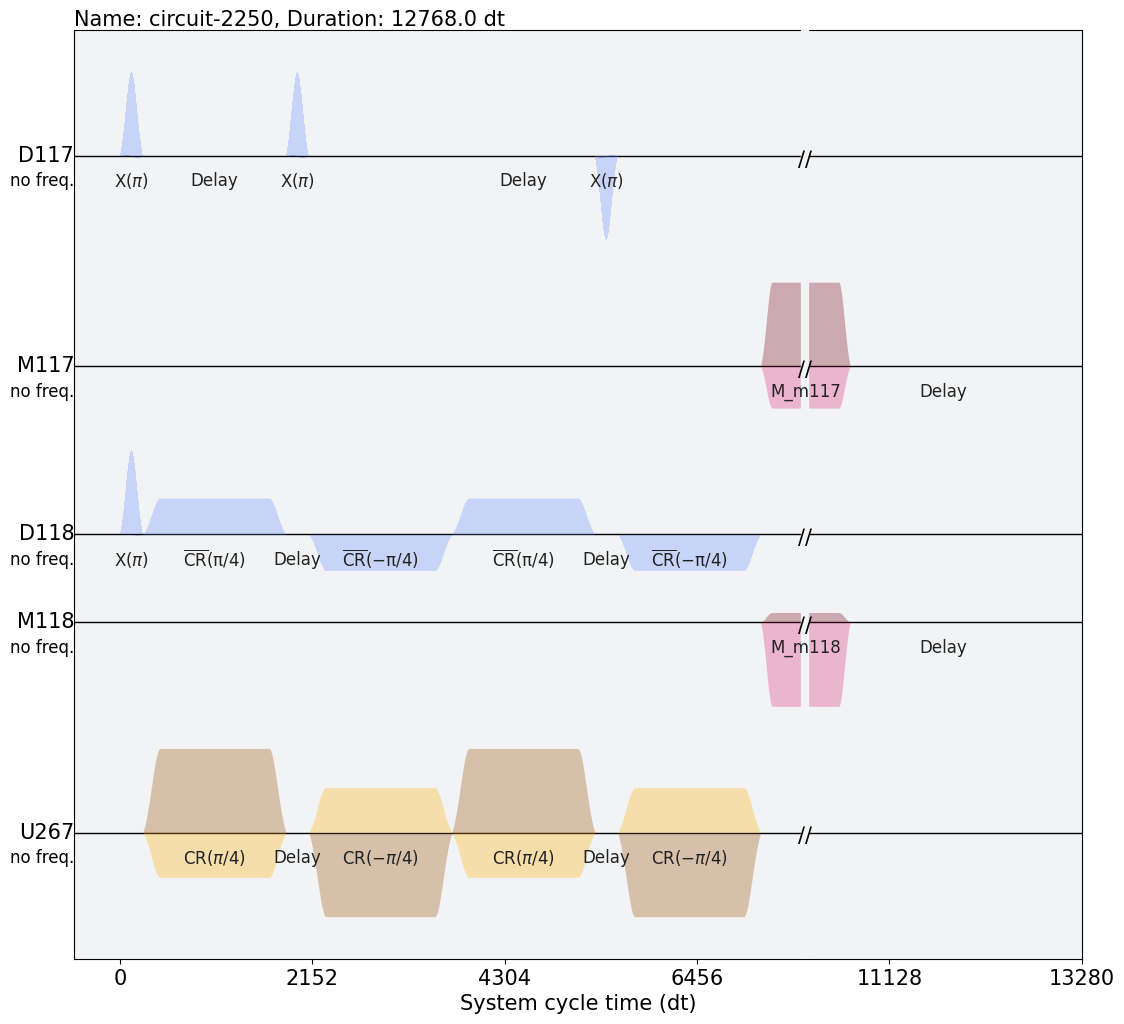

In [541]:
schedule(qc1,backend=backend_error).draw()

In [592]:

passmanager = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend_error, initial_layout=qubit_use)
qc_input = passmanager.run(trotterized_ising_circuit)
isa_observables = hamiltonian.apply_layout(qc_input.layout)
with Batch(backend = backend_error):
    estimator = EstimatorV2()
    estimator.twirlingoptions = T_options
    job = estimator.run([(qc_input, isa_observables, theta[i]) for i in range(100)])
    job.update_tags(['ecr_train',f"l={1+l}",f"stretch={stretch}","exp = x"])

In [604]:
import copy
from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit.circuit import QuantumCircuit, Gate
from qiskit.pulse import builder, DriveChannel
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2,SamplerV2
from qiskit_ibm_runtime import Session
init = '11'


error_gate = Gate(f"error", 2, [])
qc1 = QuantumCircuit(2, 2)
if init[0] == '1':
  qc1.x(0)
if init[1] == '1':
  qc1.x(1)
qc1.ecr(0,1)
qc1.ecr(0,1)
qc1.measure(0,0)
qc1.measure(1,1)

def update_ecr_real(l,init_list,backend):
  backend_copy = copy.deepcopy(backend)
  layouts = {}
  for initial_layout in init_list:
    pulse_schedule = backend_copy.target['ecr'][initial_layout].calibration
    pulse_real = ecr_to_schedule(pulse_schedule)

    if l == 0:
      backend_copy.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(pulse_real)))
    else:
      my_schedule = ecr_to_error(pulse_schedule,l)
      backend_copy.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(pulse_real+my_schedule)))



  return backend_copy




backend_ecr = update_ecr_real(l,init_list,backend)
initial_layout = init_list[0]
passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=list(initial_layout))
qc1 = passmanager.run(qc1)


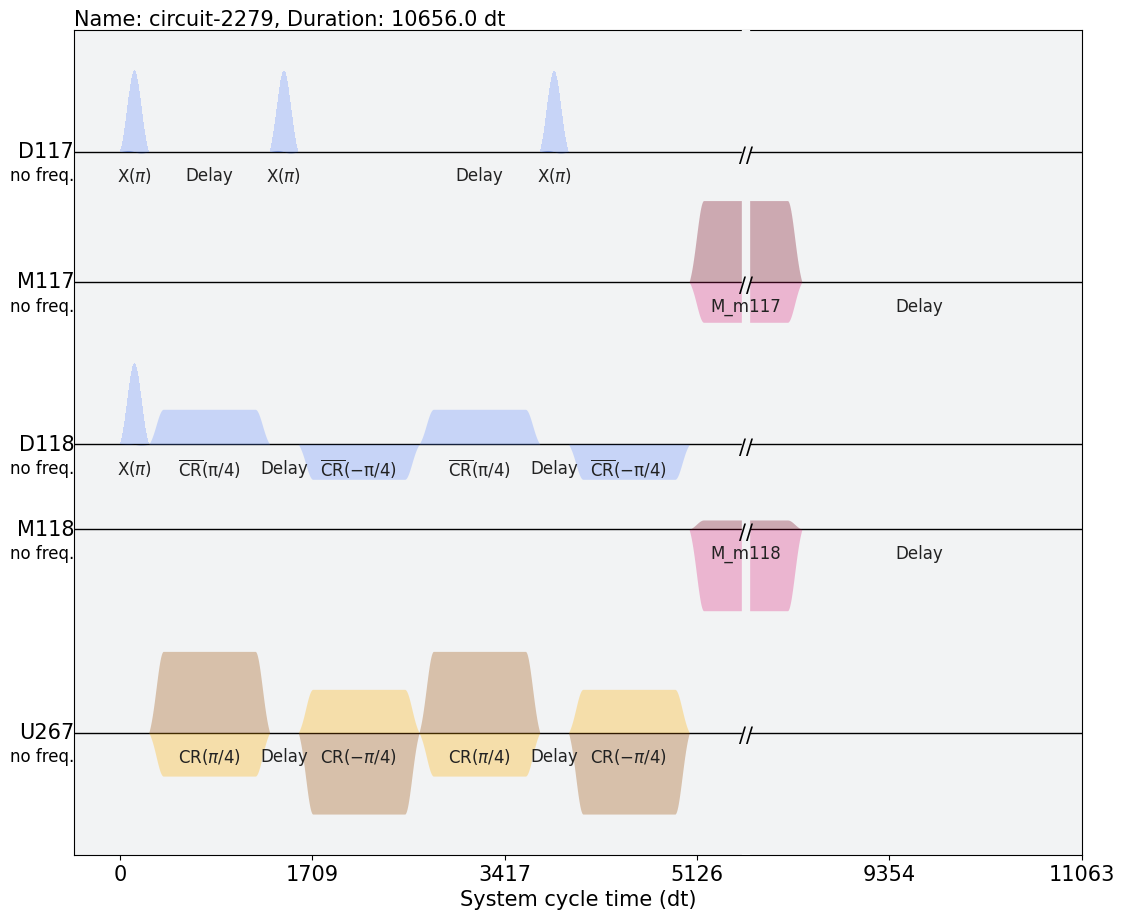

In [605]:
schedule(qc1,backend=backend_ecr).draw()

In [606]:
passmanager = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend_ecr, initial_layout=qubit_use)

from qiskit.quantum_info import SparsePauliOp
qc_input = passmanager.run(trotterized_ising_circuit)
isa_observables = hamiltonian.apply_layout(qc_input.layout)



with Batch(backend = backend_ecr):
    estimator = EstimatorV2()
    estimator.resilience_level = resilience_level
    estimator.twirlingoptions = T_options
    job = estimator.run([(qc_input, isa_observables, theta_valid[i]) for i in range(100)])
    #job = sampler.run(qc_list,shots=8000)
    job.update_tags(['ecr',f"l={1+l}","x"])

In [607]:
from qiskit.primitives import StatevectorEstimator
import torch
from qiskit.quantum_info import SparsePauliOp
estimator = StatevectorEstimator()
job_train = estimator.run([(trotterized_ising_circuit_train, hamiltonian, theta[i]) for i in range(100)])
job_valid = estimator.run([(trotterized_ising_circuit, hamiltonian, theta_valid[i]) for i in range(100)])

In [608]:
train_label = torch.tensor(np.array([result.data.evs for result in job_train.result()]),dtype=torch.float32)
validation_label = torch.tensor(np.array([result.data.evs for result in job_valid.result()]),dtype=torch.float32)
train_label = torch.reshape(train_label,[-1,1])
validation_label = torch.reshape(validation_label,[-1,1])

In [612]:
import torch
l_list = [1]
train_set = []
valid_set = []

for l in l_list:
  train_list = []
  valid_list = []

  job_train = service.jobs(backend_name=backend_name,job_tags=['ecr_train',f'l={l}'],pending=False)
  job_valid = service.jobs(backend_name=backend_name,job_tags=['ecr',f'l={l}'],pending=False)
  if len(job_train) != 0:
    job = job_train[0]
    print(job.tags)
    for res in job.result():
      train_list.append(res.data.evs)
    print(l)
    train_set.append(torch.tensor(np.array(train_list),dtype=torch.float32))


  if len(job_valid) != 0:
    for res in job_valid[0].result():
      valid_list.append(res.data.evs)
    print(l)
    valid_set.append(torch.tensor(np.array(valid_list),dtype=torch.float32))



['exp = x', 'stretch=3', 'ecr_train', 'l=1']
1
1


In [616]:
train_data = torch.stack(train_set,dim=1)
train_data = train_data.to(torch.float32)
validation_data = torch.stack(valid_set,dim=1)
validation_data = validation_data.to(torch.float32)

print(f"Raw train loss : {float(torch.nn.MSELoss()(train_data[:,0],torch.squeeze(train_label))):.4f}")
print(f"Raw valid loss : {float(torch.nn.MSELoss()(validation_data[:,0],torch.squeeze(validation_label))):.4f}")

for i in range(len(train_set)-1):
  print(f"Train difference {i,i+1} : {float(torch.nn.MSELoss()(train_data[:,i],train_data[:,i+1])):.4f}")
  print(f"Validation difference {i,i+1} : {float(torch.nn.MSELoss()(validation_data[:,i],validation_data[:,i+1])):.4f}")
#train_data = validation_data[:50]
#validation_data = validation_data[50:]
#train_label = validation_label[:50]
#validation_label = validation_label[50:]

Raw train loss : 1.0064
Raw valid loss : 2.3919


In [567]:
train_data[:,0]

tensor([-1.3975,  0.6229,  0.4945, -0.3699, -1.4530,  0.1051,  0.5066, -1.4512,
         0.0028, -0.2069, -0.3207, -0.6457, -0.5732, -1.4832, -1.3608, -1.8368,
        -1.4241,  0.9718,  0.4989,  0.1530,  0.6107, -1.4069, -0.7159, -0.7303,
        -0.4394, -0.2924, -2.3214, -1.1002,  1.2785,  0.7714,  0.2355, -0.8103,
        -0.0553,  0.4297,  0.1382,  0.7241, -0.6193, -1.5607,  0.0635, -1.1801,
         0.7538, -0.9594, -0.2045, -1.6229, -0.7086, -0.2899,  0.0581,  1.2658,
         0.9490, -0.7149,  0.2358, -0.3036, -0.0549,  0.8227, -1.6125, -0.8525,
        -0.8177,  1.0672,  0.4779, -0.3872, -1.5744, -0.6061,  0.5658, -1.8574,
         0.8317, -0.4781, -0.6508, -0.8775, -0.5234,  0.8604, -1.0978,  0.0771,
        -0.2013,  1.2512, -0.6273, -0.9444, -1.3179, -0.8763,  0.3858, -0.0914,
        -0.2298,  0.0071,  0.1774, -0.1752,  0.2634, -0.8667,  1.4661, -0.4916,
         0.2410, -0.3428, -0.7483,  0.1585,  0.3459, -1.3854,  0.8553, -0.9898,
         1.2432, -0.2571, -0.6306, -0.98

In [569]:
LSTM_list_MSE = []
LSTM_list_L1 = []

In [586]:

formula, var = model.KAN.symbolic_formula(floating_digit=5)
formula[0]

8.00729 - 12.64638*exp(-0.95799*(-0.80032*atan(0.18968*x_1 - 0.41496) - 1)**2)

In [252]:
torch.stack([predictions,validation_data[:,0],validation_label],dim=1)

tensor([[ 1.3136,  0.4279,  0.7940],
        [ 4.2394,  2.6071,  5.2146],
        [ 3.5142,  2.0962,  4.0141],
        [ 2.6401,  1.4431,  3.4236],
        [ 4.4394,  2.7455,  5.1412],
        [ 2.3853,  1.2507,  4.1436],
        [ 1.9889,  0.9519,  3.1511],
        [ 1.9264,  0.9043,  1.6495],
        [ 2.0538,  1.0011,  3.3418],
        [ 3.0908,  1.7848,  3.4617],
        [ 3.9350,  2.3949,  5.1024],
        [ 5.0272,  3.1493,  5.8597],
        [ 2.5232,  1.3546,  2.6959],
        [ 3.7858,  2.2898,  4.3727],
        [ 1.5156,  0.5871,  3.2778],
        [ 3.4551,  2.0536,  4.3911],
        [ 2.3242,  1.2047,  2.0668],
        [ 2.3599,  1.2315,  2.3113],
        [ 1.4806,  0.5597,  0.6475],
        [ 1.0449,  0.2136,  1.1359],
        [ 0.9297,  0.1215,  0.7001],
        [ 3.6010,  2.1585,  3.9027],
        [ 4.4142,  2.7281,  4.7688],
        [ 2.4537,  1.3021,  3.0240],
        [ 3.9928,  2.4354,  4.4468],
        [ 4.4530,  2.7549,  5.1162],
        [ 3.5778,  2.1419,  4.3479],
 

In [233]:
np.mean(LSTM_list_L1),np.mean(LSTM_list_MSE)

(0.6926884651184082, 0.7676637172698975)

In [79]:
with torch.no_grad():
    validation_inputs = torch.tensor(validation_data)
    predictions = torch.squeeze(model(validation_inputs))
    print(torch.stack([validation_data[:,2],validation_data[:,1],validation_data[:,0],validation_label],dim=1))

tensor([[ 7.7501e-01,  2.1546e+00,  2.6882e+00,  7.9396e-01],
        [ 1.8048e+00,  2.8134e+00,  2.5310e+00,  5.2146e+00],
        [ 4.6046e-01, -5.4833e-01,  6.3021e-01,  4.0141e+00],
        [ 4.1368e-01,  1.9859e+00,  4.7512e-01,  3.4236e+00],
        [ 1.7001e+00,  2.9055e+00,  3.2933e+00,  5.1412e+00],
        [ 2.3156e+00,  1.5186e+00,  3.2061e+00,  4.1436e+00],
        [ 1.7443e+00,  1.2393e+00,  3.0154e+00,  3.1511e+00],
        [ 6.6244e-01,  5.2147e-01,  7.0023e-01,  1.6495e+00],
        [-2.0011e-01,  1.0335e+00, -7.3144e-02,  3.3418e+00],
        [-1.1591e+00, -1.3740e-01, -7.4610e-01,  3.4617e+00],
        [ 1.0728e-01,  2.3382e-01,  9.9830e-01,  5.1024e+00],
        [ 1.4007e+00,  1.9659e+00,  2.8248e+00,  5.8597e+00],
        [ 1.6371e+00,  1.8955e+00,  2.3303e+00,  2.6959e+00],
        [ 1.7929e+00,  2.8913e+00,  3.0954e+00,  4.3727e+00],
        [ 1.6286e+00,  2.5482e+00,  3.0098e+00,  3.2778e+00],
        [ 2.5474e+00,  3.8220e+00,  4.1650e+00,  4.3911e+00],
        

<ipython-input-79-20d70c153bb3>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_data)


In [234]:
from Quantum_KAN.functions.Error_mitigation import extrapolate_values
linear_data = []
exp_data = []

for data in validation_data:
  y_linear_0,y_exp_0,_,_ = extrapolate_values(data,np.array(l_list))
  linear_data.append(y_linear_0)
  exp_data.append(y_exp_0)

linear_data = torch.tensor(np.array(linear_data),dtype=torch.float32)
exp_data = torch.tensor(np.array(exp_data),dtype=torch.float32)


TypeError: Improper input: func input vector length N=2 must not exceed func output vector length M=1

In [81]:
print(f'L1 loss : {torch.nn.L1Loss()(linear_data,validation_label)}')
print(f'MSE loss : {torch.nn.MSELoss()(linear_data,validation_label)}')

L1 loss : 1.8249717950820923
MSE loss : 5.189857006072998


In [37]:
torch.nn.L1Loss()(exp_data,validation_label)

tensor(2.0201)

In [ ]:
with torch.no_grad():
    validation_inputs = torch.tensor(validation_data)
    predictions = torch.squeeze(model(validation_inputs))
    print(torch.stack([predictions,validation_label],dim=1))

tensor([[ 9.5834e-01,  1.0988e+00],
        [ 1.9378e+00,  1.8975e+00],
        [ 1.6031e+00,  9.6113e-01],
        [ 1.5205e+00,  1.9424e+00],
        [ 3.7185e+00,  3.8195e+00],
        [-1.7447e-02, -5.8709e-01],
        [ 7.9802e-03,  2.2420e-01],
        [ 2.2131e+00,  2.3215e+00],
        [ 2.7429e+00,  3.1681e+00],
        [ 2.1032e+00,  1.7399e+00],
        [-1.1638e+00, -7.9300e-01],
        [ 3.7043e-01,  4.8473e-01],
        [ 1.9792e+00,  2.2218e+00],
        [ 2.8503e+00,  2.6846e+00],
        [ 1.4229e+00,  1.3190e+00],
        [ 2.4272e+00,  2.4113e+00],
        [-1.0895e+00, -1.1371e+00],
        [ 1.2315e+00,  1.6312e+00],
        [ 1.1559e+00,  1.4788e+00],
        [ 9.0486e-01,  1.4417e+00],
        [-5.5545e-01, -1.7112e-02],
        [ 6.5637e-01,  6.0807e-01],
        [ 2.2913e+00,  2.3657e+00],
        [-3.7699e-01,  4.3843e-03],
        [-9.8820e-02, -5.0606e-01],
        [ 6.5380e-01,  1.5706e+00],
        [ 1.0517e+00,  9.0920e-01],
        [ 1.9699e+00,  2.159

<ipython-input-67-577be693f5a7>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_data)


In [ ]:
torch.nn.MSELoss()(train_data[:,0],train_label)

tensor(2.1884)

In [ ]:
torch.nn.MSELoss()(train_data[:,0],train_label)

tensor(1.7280)

In [ ]:
torch.nn.L1Loss()(predictions,validation_label)

tensor(0.5488)

In [ ]:
torch.nn.L1Loss()(predictions,validation_label)

tensor(2.4251)

In [ ]:
torch.nn.L1Loss()(validation_data[:,0],validation_label)

tensor(1.8753)

In [ ]:
torch.nn.MSELoss()(validation_data[:,0],validation_label)

tensor(4.8845)

In [ ]:
with torch.no_grad():
    validation_inputs = torch.tensor(train_data)
    predictions = torch.squeeze(model(validation_inputs))
    print(torch.stack([predictions,train_data[:,0],train_label],dim=1))

In [ ]:
service = QiskitRuntimeService(channel='ibm_quantum',
    instance='ibm-q-skku/skku/skku-students',
    token = '06f802eeac992c43c4106753d7c5fc31414a13eb7d91c99d67fb49cc50569e5b4b011f20c71b9607a07cb43ecc7044557c699022db91d1685ba4c886d5886854')


backend = service.backend(backend_name)

In [ ]:
passmanager = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend, initial_layout=qubit_use[:4])

from qiskit.quantum_info import SparsePauliOp
np.random.seed(30)
theta = np.random.uniform(-3.14, 3.14, [100,len(trotterized_ising_circuit.parameters)])
hamiltonian = SparsePauliOp.from_list([("ZIII", 1), ("IZII", 1), ("IIZI", 1),("IIIZ", 1)])
qc_input = passmanager.run(trotterized_ising_circuit)
isa_observables = hamiltonian.apply_layout(qc_input.layout)
with Batch(backend=backend,):
    estimator = EstimatorV2()
    estimator.resilience_level = 2
    estimator.twirlingoptions = T_options
    job = estimator.run([(qc_input, isa_observables, theta[i]) for i in range(100)],precision=0.01)
    job.update_tags(['ZNE'])

In [ ]:
job = service.job('csn3wqaea560008fdveg')
job_result = job.result()
temp_result = []
for res in job_result:
    temp_result.append(res.data.evs)
temp_result = torch.tensor(np.array(temp_result),dtype=torch.float32)

In [ ]:
torch.nn.MSELoss()(temp_result,validation_label)

tensor(0.6260)

In [ ]:
torch.nn.L1Loss()(temp_result,validation_label)

tensor(0.6688)